In [17]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.io as sio
from time import time
# from bayes_opt import  BayesianOptimization
import pickle as pkl
import multiprocessing
import sys
sys.path.append(r'/home/datamake94/常用函数')
from Function import *
from datetime import datetime,timedelta

class params:
    oh_data = get_ohdata(oh_factor=['CLOSE_PRICE_2','TURNOVER_VALUE','TURNOVER_VOL','ACCUM_ADJ_FACTOR_2','OPEN_PRICE_2',\
                                   'OPEN_PRICE','CLOSE_PRICE'])
    min_data_path = r'/home/datamake94/data_nb0/min_data'
    score_dict = {
        '1d_min':r'/home/datamake94/database_00/min_score_period30/min_score_lgbm_new_agg_tabnet4',
    }

    index_path = r'/home/datamake94/data_nb0/support_data'
    support_path = r'/home/datamake94/data_nb1/trade_support'
    ohlc_path = r'/home/datamake94/data_nb0/ohlc_fea'
    test_result_path = r'/home/datamake94/data_nb0/min_factor_test_result'

    # 获取交易日列表
    trade_days_df = pd.read_csv(os.path.join(index_path,'交易日编号.csv'),index_col=0,parse_dates=True)-1 # 日期往前挪一天
    trade_days_df.index = [x.to_pydatetime().date() for x in trade_days_df.index]
    date_num = trade_days_df.reset_index().set_index('1')

    zs_w_dict = {'沪深300':0,'中证500':0,'中证1000':1}
    zs_nv_dict = {}
    for zs in ['沪深300','中证500','中证1000']:
        zs_day = pd.read_pickle(os.path.join(index_path,'index_d_close_ts.pkl'))[zs].dropna()
        zs_day.index = pd.to_datetime(zs_day.index).date
        zs_nv = zs_day / zs_day[0]
        zs_nv_dict[zs] = zs_nv.pct_change()
    zs_nv = pd.DataFrame(zs_nv_dict) @ pd.Series(zs_w_dict)
    zs_nv = zs_nv.dropna()
    zs_nv = (zs_nv+1).cumprod()
    zs_nv = zs_nv / zs_nv.iloc[0]

    # 场外信息
    os.chdir(ohlc_path)
    high_limit = pd.read_pickle('LIMIT_UP_PRICE.pkl').replace(0,np.nan).ffill()
    low_limit = pd.read_pickle('LIMIT_DOWN_PRICE.pkl').replace(0,np.nan).ffill()
    pre_close = pd.read_pickle('PRE_CLOSE_PRICE.pkl').replace(0,np.nan).ffill()
    pre_amt = pd.read_pickle('TURNOVER_VALUE.pkl').shift(1).fillna(0)
    adj_factor = pd.read_pickle('ACCUM_ADJ_FACTOR_2.pkl').replace(0,np.nan).ffill()

    upper_price = pre_close + 0.9 * (high_limit - pre_close) # 个股达到涨停价的90%就不再买入
    lower_price = pre_close + 0.9 * (low_limit - pre_close) # 个股达到跌停价的90%就不再卖出
    adj = adj_factor / adj_factor.shift(1)

    # # 读取黑名单
    # black_df = pd.read_pickle(r'/home/datamake8/data0/black_df_231120.pkl')

#获取所有的秒
min_list = []
for h in [9,10,11,13,14]:
    M = range(30,60) if h==9 else range(0,30) if h==11 else range(0,60)
    for m in M:
        min_list.extend([h*100+m])
# second_list = calc_time_series()
# second_list = sorted([x for x in second_list if int(x) >= 93000 and x <= '144500'])
params.min_list = min_list
params.min_list_valid = [x for x in params.min_list if int(x)>=1000 and int(x) <= 1457]

In [20]:
def analyse(nv,plotting=False):
    ret = nv['strategy'].diff().dropna()
    mean_ret = ret.mean() * 250
    mean_std = ret.std() * np.sqrt(250)
    sharp_ratio = mean_ret / mean_std
    dd_s = nv['strategy'].cummax() - nv['strategy']
    mean_dd = dd_s.mean()
    max_dd = dd_s.max()
    dd_date = dd_s.sort_values(ascending=False).index[0]

    new_zs = nv['zs']
    zs_ret = new_zs.diff().dropna()
    excess_ret = ret - zs_ret
    ana_ex_ret = excess_ret.mean() * 250
    ana_ex_std = excess_ret.std() * np.sqrt(250)
    info_ratio = ana_ex_ret / ana_ex_std
    rel_nv = 1 + excess_ret.cumsum()
    rel_dd_s =  rel_nv.cummax() - rel_nv
    rel_mean_dd = rel_dd_s.mean()
    rel_max_dd = rel_dd_s.max()
    rel_dd_date = rel_dd_s.sort_values(ascending=False).index[0]
    info_ratio2 = ana_ex_ret / rel_max_dd

    nv_df = pd.concat([nv['strategy'], new_zs, rel_nv], axis=1,
                      keys=['strategy', 'benchmark', 'relative'],
                      sort=False).fillna(1)
    
    if plotting is True:
        print('------绝对收益------')
        print('年化收益:' + str(mean_ret))
        print('年化波动:' + str(mean_std))
        print('夏普比率:' + str(sharp_ratio))
        print('平均回撤:' + str(mean_dd))
        print('最大回撤:' + str(max_dd))
        print('回撤日期:' + str(dd_date))
        print('------相对收益------')
        print('超额年化收益:' + str(ana_ex_ret))
        print('超额年化波动:' + str(ana_ex_std))
        print('超额夏普比率:' + str(info_ratio))
        print('超额平均回撤:' + str(rel_mean_dd))
        print('超额最大回撤:' + str(rel_max_dd))
        print('超额回撤日期:' + str(rel_dd_date))
        print('收益回撤比:' + str(info_ratio2))
        
        nv_df.plot(figsize=(40, 10))
        plt.show()

    info_s = pd.Series([ana_ex_ret, ana_ex_std, info_ratio, rel_max_dd, rel_mean_dd, rel_dd_date, info_ratio2],
                       index=['超额年化收益', '超额年化波动', '超额夏普比率', '超额最大回撤', '超额平均回撤', '超额回撤日期', '收益回撤比'])
    return info_s, nv_df, rel_nv

class stk:
    def __init__(self, code, citic1, cmvg, up_price, low_price, pre_close, minute_amt=10000,
                 trade_fee=0.0015, perm=0, perm_low=0):
        '''
        对于每只股票，创建一个对象，用于管理个股信息以及执行个股交易
        '''
        self.code = code
        self.citic = citic1  # 一级行业
        self.cmvg = cmvg  # 市值分组
        self.up_price = up_price  # 涨停价，涨停不买，跌停不卖
        self.low_price = low_price  # 跌停价
        self.pre_close = pre_close # 个股昨收价
        self.lastday_vol = 0  # 当日剩余可卖量，初始为0，持有一日之后，可卖量为前一日持有量
        self.trade_fee = trade_fee  # 交易费用与冲击成本，卖出时考虑
        self.minute_amt_b = minute_amt # 个股当前时点可买入的最大金额
        self.minute_amt_s = minute_amt # 个股当前时点可卖出的最大金额
        self.volume = 0  #  持仓量
        self.amt = 0  # 持仓市值
        self.pre_amt = 0 # 根据昨收价计算的个股配置市值
        self.perm = perm # 个股持仓上限
        self.perm_low = perm_low # 个股持仓下限
        self.minimum_vol = 200 if ('%06d'%int(code))[:2]=='68' else 100 # 68开头的沪市科创板股票最少交易200股
        self.hold_date = 0  # 个股已持仓日期数
    
    def update_info(self, citic1, cmvg, up_price, low_price, pre_close, perm,perm_low, trade_fee=0.0015): # 每日开盘刷新个股行业、市值分组、涨跌停价等
        self.citic = citic1  # 一级行业
        self.cmvg = cmvg  # 市值分组
        self.up_price = up_price  # 涨停价
        self.low_price = low_price  # 跌停价
        self.pre_close = pre_close # 个股昨收价
        self.pre_amt = pre_close * self.volume # 个股昨收市值
        self.perm = perm # 个股持仓上限
        self.perm_low = perm_low # 个股持仓下限
        self.trade_fee = trade_fee
        
    def update_price(self, price):  # 更新个股的价格以及持仓市值
        self.price = price
        self.amt = self.volume * price

    def buy(self, volume):  # 买入个股，记录成交信息，刷新持仓市值，返回成交金额；
        amt = volume * self.price # 当前买入金额
        pre_amt = volume * self.pre_close # 买入调整的配置市值
        self.volume += volume  # 更新个股累计持仓量
        self.amt = self.volume * self.price  #更新个股累计持仓市值
        self.pre_amt = self.volume * self.pre_close # 根据昨收价计算的个股配置市值
        self.minute_amt_b -= amt # 当前分钟可买入金额减少
        return (amt, pre_amt, self.volume, self.amt)  # 返回买入金额，配置新增额，持仓量、持仓市值
        
    def sell(self, volume):  # 卖出个股，记录成交信息，刷新持仓市值，返回成交金额；
        amt = volume * self.price * (1-self.trade_fee)  # 卖出时扣除手续费和冲击成本
        pre_amt = volume * self.pre_close # 卖出调整的配置市值
        self.volume -= volume # 更新个股持仓量
        self.lastday_vol -= volume # 更新个股当日可卖量
        self.minute_amt_s -= amt # 当前分钟可卖出金额减少
        self.amt = self.volume * self.price # 更新个股持仓市值
        self.pre_amt = self.volume * self.pre_close # 根据昨收价计算的个股配置市值
        return (amt, pre_amt, self.volume, self.amt)  # 返回卖出金额，配置减少额，持仓量、持仓市值

class account:
    '''
    创建一个账户类，用于刷新账户信息，管理股票信息，规划交易任务以及执行
    '''
    def __init__(self,money):
        self.code_list = []  # 可考虑的股票列表
        self.tot_account = money  # 总资产，初始化为总现金
        self.stk_dict = {}  # 全市场股票信息
        self.hold_dict = {}  # 持仓股票信息
        self.trade_dict = {}  # 个股交易记录，分股票
        
        self.decision_list = []  # 记录决策列表
        self.time = ' '  # 当前时间戳
        self.cash = money
    
    def cal_tot(self): # 刷新持仓信息，统计账户总市值
        tot = 0
        for code in self.hold_dict.keys():
            self.hold_dict[code] = [self.stk_dict[code].volume, self.stk_dict[code].amt]
            tot += self.stk_dict[code].amt
        self.tot_account = tot+self.cash
        return self.tot_account
    
    def refresh_open(self, code_list,td_citic,td_cmvg,td_upper,td_lower,td_pre_close,td_citic_perm,td_cmvg_perm,stk_perm,date_str):  # 每天开盘刷新策略持仓相关信息
        '''
        code_list 为当日可考虑的股票池
        td_citic 全市场个股行业信息
        td_cmvg 全市场市值分组信息
        td_upper 全市场个股当日涨停价
        td_lower 全市场个股当日跌停价
        td_citic_perm 当前账户可允许的各行业最大持仓市值、最小持仓市值，会在指数的行业分布基础上下浮动
        td_cmvg_perm 当前账户可允许的各市值组最大持仓市值、最小持仓市值，会在指数的市值分布基础上下浮动
        stk_perm 当前账户各股票可允许的最大持仓市值，会在指数的个股持仓基础上调整
        '''
        
        if date_str < '20230828': trade_fee = 0.0015
        else: trade_fee = 0.001
        for code in code_list: # 开盘刷新所有个股信息，可能有新上市的，可能有市值分组变动的，涨跌停价格也会发生变化
            if code not in self.stk_dict.keys():  # 新上市股票信息新增
                self.stk_dict[code] = stk(code,td_citic[code],td_cmvg[code],td_upper[code], td_lower[code],td_pre_close[code],perm=stk_perm[1][code],perm_low=stk_perm[0][code],trade_fee=trade_fee)
            else:   # 已上市股票信息刷新
                self.stk_dict[code].update_info(td_citic[code], td_cmvg[code], td_upper[code], td_lower[code],td_pre_close[code],stk_perm[1][code],stk_perm[0][code],trade_fee=trade_fee) # 更新个股行业、市值、涨跌停价等
                
        self.citic_amt = {}  # 个股行业暴露
        self.cmvg_amt = {}  # 个股市值分组暴露
        for code in self.hold_dict.keys():
#             sellable = (self.stk_dict[code].pre_amt-self.stk_dict[code].perm_low) / self.stk_dict[code].pre_close
#             if sellable>self.stk_dict[code].minimum_vol or self.stk_dict[code].perm_low / self.stk_dict[code].pre_close > self.stk_dict[code].minimum_vol:
#                 self.stk_dict[code].lastday_vol = min(self.stk_dict[code].volume, self.stk_dict[code].minimum_vol*(sellable // self.stk_dict[code].minimum_vol) ) # 已持仓股票今日可以全部卖出
#             else:
#                 self.stk_dict[code].lastday_vol = min(self.stk_dict[code].volume, self.stk_dict[code].minimum_vol)
            self.stk_dict[code].lastday_vol = self.stk_dict[code].volume # 当日可卖量
            self.stk_dict[code].hold_date += 1  # 持仓日期数加1
            pre_amt = self.stk_dict[code].pre_amt
            citic0 = self.stk_dict[code].citic
            cmvg0 = self.stk_dict[code].cmvg
            if citic0 not in self.citic_amt.keys():self.citic_amt[citic0] = 0
            self.citic_amt[citic0] += pre_amt
            if cmvg0 not in self.cmvg_amt.keys():self.cmvg_amt[cmvg0] = 0
            self.cmvg_amt[cmvg0] += pre_amt
            
        self.citic_perm_b = {x:(td_citic_perm[1][x]-self.citic_amt[x] if x in self.citic_amt.keys() else td_citic_perm[1][x])  for x in td_citic_perm[1].keys()} # 当日各行业剩余可买额度
        self.cmvg_perm_b = {x:(td_cmvg_perm[1][x]-self.cmvg_amt[x] if x in self.cmvg_amt.keys() else td_cmvg_perm[1][x])  for x in td_cmvg_perm[1].keys()}  # 当日各市值分组剩余可买额度
        self.citic_perm_s = {x:(self.citic_amt[x]-td_citic_perm[0][x] if x in self.citic_amt.keys() else 0 )  for x in td_citic_perm[0].keys()} # 当日各行业剩余可卖额度
        self.cmvg_perm_s = {x:(self.cmvg_amt[x]-td_cmvg_perm[0][x] if x in self.cmvg_amt.keys() else 0 )  for x in td_cmvg_perm[0].keys()}  # 当日各市值分组剩余可卖额度
        return self.cal_tot()
    
    def log_trade(self, code, price, bsvolume): # 交易记录
        if code not in self.trade_dict.keys():
            self.trade_dict[code] = []
        self.trade_dict[code].append([bsvolume, price, self.time])
    
    def update_perm(self, code, pre_amt): # 刷新策略的行业、市值暴露额度
        '''
        每当有买入或者卖出成交时，对应的行业及市值组持仓市值会变化，所以相应改变剩余可买额度，和可卖额度
        当买入个股时，amt>0，需要减少对应的可买额度，增加可卖额度
        当卖出个股时，amt<0，需要增加对应的可买额度，减少可卖额度
        '''
        citic0 = self.stk_dict[code].citic
        cmvg0 = self.stk_dict[code].cmvg
        self.citic_perm_b[citic0] -= pre_amt
        self.cmvg_perm_b[cmvg0] -= pre_amt
        self.citic_perm_s[citic0] += pre_amt
        self.cmvg_perm_s[cmvg0] += pre_amt

    def buy_stk(self, code, volume): # 买入股票
        amt, pre_amt, hold_vol, hold_amt = self.stk_dict[code].buy(volume)
        self.log_trade(code,self.stk_dict[code].price, volume)
        self.update_perm(code, pre_amt)
        self.hold_dict[code] = (hold_vol, hold_amt)
        self.stk_dict[code].hold_date = 0  # 买入后持仓日期数归零
        self.cash -= amt
        if self.cash<0:
            raise ValueError(code+':'+str(volume)+'现金不足买入')
        return amt
    
    def sell_stk(self, code, volume): # 卖出股票
        amt, pre_amt, hold_vol, hold_amt = self.stk_dict[code].sell(volume)
        self.log_trade(code,self.stk_dict[code].price, -volume)
        self.update_perm(code, -pre_amt)
        if hold_vol>0:
            self.hold_dict[code] = (hold_vol, hold_amt)
        else:
            del self.hold_dict[code] # 清仓后不再持有该只个股
        self.cash += amt
        return amt

    def fresh_minute(self, minute_amt_dict,price_s): # 每分钟刷新个股的分钟可参与金额和成交价
        for code in minute_amt_dict.keys():
            try:
                self.stk_dict[code].minute_amt_b = minute_amt_dict[code]
                self.stk_dict[code].minute_amt_s = minute_amt_dict[code]
                self.stk_dict[code].update_price(price_s[code])  # 刷新个股价格
            except:
                pass
        
    def fresh_price(self, price_s,td_adj=None): # 每分钟刷新个股的分钟收盘价
        if td_adj is None:
            return
        else:
            for code in td_adj:
                if code in self.hold_dict.keys():
                    self.stk_dict[code].volume = self.stk_dict[code].volume * td_adj[code] # 调整个股持仓量
                    self.hold_dict[code][0] = self.stk_dict[code].volume
        
        for code in price_s.keys():
            try:
                self.stk_dict[code].update_price(price_s[code])  # 刷新个股价格
            except:
                pass
    
    def decide_clean(self, max_buy, max_sell, buy_codes, sell_codes, buy_codes2, min_turnlimit = 1): # 每分钟根据最新的打分排序，以及可以买卖的金额，做出任务计划
        '''
        max_buy 当前分钟可买入金额
        max_sell 当前分钟可卖出金额
        buy_codes 考虑买入的股票池，根据打分从大到小排序
        sell_codes 考虑卖出的股票池，根据打分从小到大排序
        '''
        tot_buy_amt = 0
        tot_sell_amt = 0
        ans_str = self.time
        min_turn_value = self.tot_account * min_turnlimit # 限制当前分钟最大可卖量
        for i in range(1): # 由于买卖会交互影响行业、市值额度，需要多次循环遍历来确认最终任务
            if max_sell>0:
                for sell_code in sell_codes: #从可卖列表从前往后找，可卖则卖
                    if tot_sell_amt <= max_sell-100 and tot_sell_amt <= min_turn_value:   # 直至无法添加
                        stk_now = self.stk_dict[sell_code]
                        price = stk_now.price
                        pre_close = stk_now.pre_close
                        unit_vol = stk_now.minimum_vol
                        if (stk_now.lastday_vol>0) and (stk_now.pre_amt>stk_now.perm_low) and (stk_now.minute_amt_s>100) and \
                        (stk_now.price>stk_now.low_price) and (stk_now.price<stk_now.up_price):
                            sellable_vol = min( int( min(stk_now.minute_amt_s / (unit_vol*price), 
                                                       (max_sell-tot_sell_amt) / (unit_vol*price),
                                                        (stk_now.pre_amt - stk_now.perm_low) / (unit_vol*pre_close)) ) * unit_vol, stk_now.lastday_vol) 
                             
                            
                            if sellable_vol>=unit_vol or sellable_vol==stk_now.lastday_vol:
                                tot_sell_amt += self.sell_stk(sell_code,sellable_vol)
                                ans_str += ' S:'+sell_code+':'+str(sellable_vol)
                    else:
                        break  # 无法继续换仓
            if max_buy>0:
                for buy_code in self.need_check_stk: # 这个循环用于检查持仓是否达到下限
                    if tot_buy_amt <= max_buy-1000: # 直至无法添加
                        stk_now = self.stk_dict[buy_code]
                        if stk_now.pre_amt > stk_now.perm_low:
                            continue
                        price = stk_now.price
                        pre_close = stk_now.pre_close
                        unit_vol = stk_now.minimum_vol
                        to_fill_amt = stk_now.perm_low - stk_now.pre_amt
                        if (stk_now.pre_amt<stk_now.perm) and (stk_now.minute_amt_b>100) and (stk_now.price<stk_now.up_price) and (stk_now.price>stk_now.low_price):
                            buyable_vol = int(min(stk_now.minute_amt_b / (unit_vol*price), 
                                                    (stk_now.perm-stk_now.pre_amt) / (unit_vol*pre_close), 
                                                    (max_buy-tot_buy_amt) / (unit_vol*price), 
                                                    to_fill_amt / (unit_vol*pre_close) ) ) * unit_vol
                            if buyable_vol>=unit_vol:
                                tot_buy_amt += self.buy_stk(buy_code,buyable_vol)
                                ans_str += ' B:'+buy_code+':'+str(buyable_vol)
                    else:
                        break
                
                if min([self.cmvg_perm_s[k] for k in self.cmvg_perm_s.keys()])<0 or min([self.citic_perm_s[k] for k in self.citic_perm_s.keys()])<0:
                    for buy_code in buy_codes2: # 这个循环用来寻找填补行业、市值分组下限的可买入股票
                        if tot_buy_amt <= max_buy-1000: # 直至无法添加
                            stk_now = self.stk_dict[buy_code]
                            cmvg_perm_s = self.cmvg_perm_s[stk_now.cmvg] 
                            citic_perm_s = self.citic_perm_s[stk_now.citic] 
                            if cmvg_perm_s>0 and citic_perm_s>0: # 
                                continue
                            else:
                                to_fill_amt = max(-cmvg_perm_s, -citic_perm_s) # max始终为正
                                cmvg_perm = self.cmvg_perm_b[stk_now.cmvg]
                                citic_perm = self.citic_perm_b[stk_now.citic]
                                price = stk_now.price
                                pre_close = stk_now.pre_close
                                unit_vol = stk_now.minimum_vol
                                if (cmvg_perm>0) and (citic_perm>0) and (stk_now.pre_amt<stk_now.perm) and (stk_now.minute_amt_b>100) and \
                                (stk_now.price<stk_now.up_price) and (stk_now.price>stk_now.low_price):
                                    buyable_vol = int(min(stk_now.minute_amt_b / (unit_vol*price), 
                                                          (stk_now.perm-stk_now.pre_amt) / (unit_vol*pre_close), 
                                                          (max_buy-tot_buy_amt) / (unit_vol*price), 
                                                          cmvg_perm / (unit_vol*pre_close), 
                                                          citic_perm / (unit_vol*pre_close), 
                                                          to_fill_amt / (unit_vol*pre_close) ) ) * unit_vol

                                    if buyable_vol>=unit_vol:
                                        tot_buy_amt += self.buy_stk(buy_code,buyable_vol)
                                        ans_str += ' B:'+buy_code+':'+str(buyable_vol)
                        else:
                            break
                        
                for buy_code in buy_codes: # 从可买列表往后找，可买则买
                    if tot_buy_amt <= max_buy-1000: # 直至无法添加
                        stk_now = self.stk_dict[buy_code]
                        cmvg_perm = self.cmvg_perm_b[stk_now.cmvg]
                        citic_perm = self.citic_perm_b[stk_now.citic]
                        price = stk_now.price
                        pre_close = stk_now.pre_close
                        unit_vol = stk_now.minimum_vol
                        if (cmvg_perm>0) and (citic_perm>0) and (stk_now.pre_amt<stk_now.perm) and (stk_now.minute_amt_b>100) and \
                        (stk_now.price<stk_now.up_price) and (stk_now.price>stk_now.low_price) :
                            buyable_vol = int(min(stk_now.minute_amt_b / (unit_vol*price), 
                                                  (stk_now.perm-stk_now.pre_amt) / (unit_vol*pre_close), 
                                                  (max_buy-tot_buy_amt) / (unit_vol*price), 
                                                  cmvg_perm / (unit_vol*pre_close), 
                                                  citic_perm / (unit_vol*pre_close) ) ) * unit_vol #self.stk_dict[buy_code].buyable
                            
                            if buyable_vol>=unit_vol:
                                tot_buy_amt += self.buy_stk(buy_code,buyable_vol)
                                ans_str += ' B:'+buy_code+':'+str(buyable_vol)
                    else:
                        break
                        
        ans_str +=' BM:'+str(round(tot_buy_amt,2)) + ' SM:'+str(round(tot_sell_amt,2))
        self.decision_list.append(ans_str)
        return tot_buy_amt,tot_sell_amt
        
    def close_today(self): # 每日收盘整理
        hold_df = pd.DataFrame(self.hold_dict).T.sort_index()
        trade_df = pd.concat([pd.DataFrame(self.trade_dict[x]) for x in self.trade_dict.keys()],keys=self.trade_dict.keys()).reset_index() if len(self.trade_dict)>0 else pd.DataFrame(columns=['code','idx','volume','price','time'])
        trade_df.columns = ['code','idx','volume','price','time']
        del trade_df['idx']
        trade_df.sort_values(['time'])
        self.trade_dict = {}
        decision_s = pd.Series(self.decision_list,dtype=object)
        self.decision_list = []
        for code in self.stk_dict.keys():
            if self.stk_dict[code].volume == 0:
                self.stk_dict[code].hold_date = 0
        return hold_df, trade_df, decision_s

In [21]:
start_date = '20240102'
end_date = '20240630'
date_list = get_datelist(start_date,end_date,params.oh_data)[:]
date_list = [datetime.strptime(x[:8],"%Y%m%d").date() for x in date_list]
date_list_all = get_datelist_all(params.oh_data)
date_list_all = [datetime.strptime(x[:8],"%Y%m%d").date() for x in date_list_all]
# idx = 'hs300'
# idx_name = '沪深300'

In [27]:
def get_min_data(date,date_str):
    pre_date_price = params.pre_close.loc[date]
    min_data = pd.read_feather(params.min_data_path + '//' + date_str + '.fea')
    min_data['StockID'] = min_data['StockID'].apply(lambda x:x[2:]).astype(str)
    min_data['time'] = min_data['time'].astype(int)
    #需要转换time的格式，与因子的对齐
    min_data['time'] = min_data['time'].apply(lambda x:x-40-1 if x%100==0 else x-1)
    vol_data = min_data[['time','StockID','vol']].pivot_table(index='time',columns='StockID',values='vol').sort_index(axis=0).sort_index(axis=1).fillna(0)
    amt_data = min_data[['time','StockID','amount']].pivot_table(index='time',columns='StockID',values='amount').sort_index(axis=0).sort_index(axis=1)
    vwap_data = (amt_data/vol_data).fillna(method='ffill')
    vwap_data.loc[920] = pre_date_price.reindex(index=vwap_data.columns)
    vwap_data = vwap_data.sort_index(axis=0).fillna(method='ffill')
    amt_data.loc[929] = params.pre_amt.loc[date].reindex(index=amt_data.columns) * 0.02
    amt_data = amt_data.shift(1)
    amt_data = amt_data.sort_index(axis=0).sort_index(axis=1).fillna(0)
    return vwap_data,amt_data

def get_alpha_dict(date_str,code_list = [],inday_ratio = 0.7,score_type={'tabnet':0.5}, load=False):
    if load:
        with open(r'/home/datamake8/data0/min_alpha_agg/update20240618/%s.pkl'%date_str,'rb') as f:
            (min_score) = pkl.load(f)
        min_score = min_score.reindex(columns=code_list)
        # daily_score = daily_score.reindex(index=code_list)
        daily_score = pd.read_feather(r'/home/datamake8/database_00/lzscore_20240426.fea').set_index('index')
        daily_score = daily_score.loc[date_str]
        alpha_dict = {}
        alpha_dict['1d_min'] = min_score
        alpha_dict['1d_daily'] = daily_score
        return alpha_dict
    # 获取打分文件
    alpha_dict = {}

    factor_score_min_total = []
    if date_str < '20240102':
        score_path = params.score_dict['1d_min']
    else:
        score_path = params.score_dict['1d_min']
    factor_score_1d_min = pd.read_feather(score_path + '//%s.fea'%date_str).set_index('index')
    factor_score_1d_min = factor_score_1d_min.shift(1)
    factor_score_1d_min.index = factor_score_1d_min.index.astype(int)
    factor_score_1d_min.columns = factor_score_1d_min.columns.astype(int)
    factor_score_1d_min.columns = ['%06d'%x for x in factor_score_1d_min.columns]
    factor_score_1d_min = factor_score_1d_min.reindex(columns=code_list).fillna(method='ffill') if len(code_list) != 0 else factor_score_1d_min.fillna(method='ffill')
    factor_score_1d_min = factor_score_1d_min.rank(pct=True,axis=1).fillna(0.5)
    alpha_dict['1d_min'] = factor_score_1d_min
    # factor_score_1d_min = factor_score_1d_min.rank(pct=True,axis=1).fillna(0.5)
    # factor_score_1d_min = ((factor_score_1d_min.T - factor_score_1d_min.mean(axis=1)) / factor_score_1d_min.std(axis=1)).T.fillna(0)

    # alpha_dict['1d_min'] = (factor_score_1d_min * inday_ratio + factor_score_1d_agg * (1-inday_ratio))
    # alpha_dict['1d_min'] = alpha_dict['1d_min'].rank(pct=True,axis=1).fillna(0.5)

    #加入LZ的日频打分
    # daily_score = pd.read_feather(r'/home/datamake8/database_00/lzscore_20240426.fea').set_index('index')
    # daily_score = daily_score.loc[date_str]
    # daily_score = daily_score.reindex(code_list).rank(pct=True).fillna(0.5) if len(code_list) != 0 else daily_score.rank(pct=True).fillna(0.5)
    # alpha_dict['1d_daily'] = daily_score

    if len(code_list) != 0:
        for name in alpha_dict.keys():
            alpha_dict[name] = alpha_dict[name].reindex(index=code_list) if name=='1d_daily' else alpha_dict[name].reindex(columns=code_list)

    return alpha_dict

def func_backtest(citic_share_limit,cmvg_share_limit,citic_share_limit_low,cmvg_share_limit_low,stk_holding_limit,
                  stk_holding_limit_low,buy_rank_ratio, 
                  cash_limit_high,stk_trade_share=0.05,initial_money=100000000,sell_rank_ratio_morning=1,sell_rank_ratio_noon=1,inday_ratio=0.7,min_turn_limit=1,save_result=False):
    
    # initial_money = 100000000 # 初始资金
    s = account(initial_money) # 策略初始化
    s.cal_tot()
    s.time = date_list[0].strftime('%Y%m%d')
    # sell_rank_ratio = min(1-buy_rank_ratio,sell_rank_ratio)

    para = {'im':initial_money/100000000,
              'ci':citic_share_limit,
              'mv':cmvg_share_limit,
              'cl':citic_share_limit_low,
              'ml':cmvg_share_limit_low,
              'sh':stk_holding_limit,
              'sl':stk_holding_limit_low,
              'st':stk_trade_share,
              'ch':cash_limit_high,
              'br':buy_rank_ratio,
              #'sr':sell_rank_ratio}
              'srm':sell_rank_ratio_morning,
              'srn':sell_rank_ratio_noon}

    hold_df_dict = {} # 保存每日持仓记录
    trade_df_dict = {} # 保存每日交易记录
    decision_dict = {} # 保存每日交易决策记录
    tot_account_dict = {} # 保存每日每分钟现金、总持仓金额、换手金额等
    rank_df = {} # 保存每日每分钟平均持仓排名
    max_dd = 0 # 最大回撤

    for num in range(len(date_list)): #tqdm(num_list[721:841], desc=str(num_list[721])+'--'+str(num_list[841]),ascii=True):
        date = date_list[num]
        date_str = date.strftime('%Y%m%d')
        pre_date = date_list_all[date_list_all.index(date)-1]
        pre_date_str = pre_date.strftime('%Y%m%d')
        if date_str <= '20231113':
            td_black = params.black_df.loc[date].replace(False,np.nan).dropna().index.tolist() # 当日黑名单
        else:
            td_black = pd.read_csv(r'/home/datamake94/data_nb1/black_list/%s_black_list.csv'%date_str,index_col=0)
            td_black = td_black[td_black['black']==True].index.tolist()
        
        # 获取alpha数据
        # os.chdir(test_path)

        os.chdir(params.support_path)
        td_support = pd.read_csv(date_str+'_trade_support.csv')  # 当天盘前可获取到的信息
        td_support['index'] = td_support['index'].apply(lambda x:'%06d'%x)
        td_support = td_support.rename({'index':'code'},axis=1).set_index('code',drop=True)
        
        close_price,min_amt = get_min_data(date,date_str)
        close_price = close_price.T
        min_amt = min_amt.T
        close_price.columns = close_price.columns.astype(int)
        
        # 提取个股信息
        td_upper = params.upper_price.loc[date].dropna()
        td_lower = params.lower_price.loc[date].dropna()
        td_preclose = params.pre_close.loc[date].dropna()
        td_citic = td_support['citic1_code']
        td_cmvg = td_support['cmv_group']
        td_adj = params.adj.loc[date].replace(1,np.nan).dropna().to_dict()
        code_list = pd.concat([td_citic, td_cmvg, td_upper,td_lower,close_price[930]],axis=1).dropna(how='any').index.tolist() # 今日可考虑的正常交易的股票列表

        sub_code = (td_support['ipo_dates']>20) & (td_support['st']==0) # 筛选中证1000成分股、上市20交易日以上、非ST股票
        sub_code_list = sub_code[sub_code].index.tolist()
        code_list = [x for x in code_list if x[:2] in ['00','30','60','68']]
        code_list = [x for x in code_list if x in sub_code_list] # 再根据信息情况取交集
        code_list = [x for x in code_list if x not in td_black]

        if max_dd > -0.0075 or np.isnan(max_dd):
            td_citic_share_limit_low,td_citic_share_limit = citic_share_limit_low,citic_share_limit
            td_cmvg_share_limit_low,td_cmvg_share_limit = cmvg_share_limit_low,cmvg_share_limit
            # allow_divid = pd.Series({0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:1}) * cmvg_share_limit
            # allow_divid = pd.Series({0:0.05,1:0.1,2:0.05,3:0.05,4:0.07,5:0.06,6:0.02})
            allow_divid = pd.Series({0:0.02,1:0.03,2:0.05,3:0.07,4:0.05,5:0.03,6:0.02})
        elif max_dd > -0.015:
            td_citic_share_limit_low,td_citic_share_limit = citic_share_limit_low*0.5,citic_share_limit*0.5
            td_cmvg_share_limit_low,td_cmvg_share_limit = cmvg_share_limit_low*0.5,cmvg_share_limit*0.5
            # allow_divid = pd.Series({0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:1}) * cmvg_share_limit
            allow_divid = pd.Series({0:0.02,1:0.03,2:0.05,3:0.07,4:0.05,5:0.03,6:0.02})

        else:
            td_citic_share_limit_low,td_citic_share_limit = citic_share_limit_low*0.25,citic_share_limit*0.25
            td_cmvg_share_limit_low,td_cmvg_share_limit = cmvg_share_limit_low,cmvg_share_limit
            # allow_divid = pd.Series({0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:1}) * cmvg_share_limit
            allow_divid = pd.Series({0:0.02,1:0.03,2:0.05,3:0.07,4:0.05,5:0.03,6:0.02})
#         td_citic_share_limit_low,td_citic_share_limit = citic_share_limit_low,citic_share_limit
#         td_cmvg_share_limit_low,td_cmvg_share_limit = cmvg_share_limit_low,cmvg_share_limit
        td_inday_ratio = inday_ratio
        
        hold_black = []
        dumb_stk = []
        valid_t0_list = []
        for code in s.hold_dict.keys():
            if code not in code_list:
                code_list.append(code)
                
            if code in td_black:
                hold_black.append(code)

            if s.stk_dict[code].hold_date >= 20:
                dumb_stk.append(code)
                
            valid_t0_list.append(code)
                
        # td_alpha2 = td_alpha.T.reindex([code for code in code_list if code not in td_black]).to_dict('series') # 只考虑当日可用股票池，并剔除黑名单股票
        
        s.fresh_price(td_preclose, td_adj)
        s.cal_tot()

        
        # 提取指数信息
        zs_citic_dict, zs_cmvg_dict, zs_member_dict = {}, {}, {}
        for idx in ['hs300','zz500','zz1000']:
            zs_citic = td_support[['citic1_code',idx+'_citic1']].drop_duplicates('citic1_code').set_index('citic1_code')[idx+'_citic1'].sort_index()
            zs_cmvg = td_support[['cmv_group',idx+'_cmvg']].drop_duplicates('cmv_group').set_index('cmv_group')[idx+'_cmvg'].sort_index()
            zs_member = td_support[idx+'_member']
            zs_citic_dict[idx] = zs_citic
            zs_cmvg_dict[idx] = zs_cmvg
            zs_member_dict[idx] = zs_member
        zs_weight = pd.Series(params.zs_w_dict)
        zs_citic = sum([zs_citic_dict[idx].fillna(0)*zs_weight[{'hs300':'沪深300','zz500':'中证500','zz1000':'中证1000'}[idx]] for idx in ['hs300','zz500','zz1000']])
        zs_cmvg = sum([zs_cmvg_dict[idx].fillna(0)*zs_weight[{'hs300':'沪深300','zz500':'中证500','zz1000':'中证1000'}[idx]] for idx in ['hs300','zz500','zz1000']])
        zs_member = sum([zs_member_dict[idx].fillna(0)*zs_weight[{'hs300':'沪深300','zz500':'中证500','zz1000':'中证1000'}[idx]] for idx in ['hs300','zz500','zz1000']])
        # 提取约束信息
        low_citic = zs_citic-td_citic_share_limit_low
        low_citic[low_citic<0]=0
        td_citic_perm = [(low_citic * s.tot_account).to_dict(), ((zs_citic+td_citic_share_limit) * s.tot_account).to_dict()]

        # low_cmvg = zs_cmvg-td_cmvg_share_limit_low
        # low_cmvg[low_cmvg<0]=0
        # td_cmvg_perm = [(low_cmvg * s.tot_account).to_dict(), ((zs_cmvg+td_cmvg_share_limit) * s.tot_account).to_dict()]
#         allow_divid = pd.Series({0:0,1:0.05,2:0.07,3:0.07,4:0.05,5:0.03,6:0})
        low_cmvg = zs_cmvg-2*allow_divid
        low_cmvg[low_cmvg<0]=0
        td_cmvg_perm = [(low_cmvg * s.tot_account).to_dict(), ((zs_cmvg+allow_divid) * s.tot_account).to_dict()]

        stk_low = (zs_member - stk_holding_limit_low) * s.tot_account
        stk_low[stk_low<0] = 0
        stk_perm = [stk_low.to_dict(), ((zs_member + stk_holding_limit) * s.tot_account).to_dict()]

        cash_high = cash_limit_high * s.tot_account # 最多持仓现金
        buy_length = round(len(code_list)*buy_rank_ratio)
        # sell_length = round(len(code_list)*sell_rank_ratio)

        min_sec_list = sorted(close_price.columns.tolist())
        trade_min_sec = [x for x in min_sec_list if (x>929.0) and (x<1000.0)] #  and (x != round(x))


        # 开盘前刷新参数
        account0 = s.refresh_open(code_list,td_citic.to_dict(),td_cmvg.to_dict(),td_upper.to_dict(),td_lower.to_dict(),td_preclose.to_dict(),td_citic_perm,td_cmvg_perm,stk_perm,date_str)
        alpha_dict = get_alpha_dict(date_str,code_list,inday_ratio=td_inday_ratio,load=False)
        s.need_check_stk = [code for code in s.stk_dict.keys() if s.stk_dict[code].perm_low > 0]

        # print('standard turn amt',min_turn_std)
        account_s = {} # pd.Series([account0]*len(minute_list),index=minute_list)
        cash_s = {} # pd.Series([0]*len(minute_list),index=minute_list)
        buy_s = {} # pd.Series([0]*len(minute_list),index=minute_list)
        sell_s = {}
        rank_s = {}
        for m in min_sec_list: #minute_list[1:]:#  # 从0930开始，刷新分钟行情，获取当前分钟alpha信号，设置alpha阈值，做出交易决策
            s.time = date_str+' '+str(m)
            sell_length = round(len(code_list)*sell_rank_ratio_morning) if m<=1000 or m>=1430 else round(len(code_list)*sell_rank_ratio_noon)
            sell_ratio = sell_rank_ratio_morning if m<=1000 or m>=1430 else sell_rank_ratio_noon
            buy_ratio = buy_rank_ratio
            if m <= 930 or m >= 1500:
                min_price_s = close_price[m]
                s.fresh_price(min_price_s.to_dict())
                buy_amt,sell_amt = 0,0
            elif m in trade_min_sec:
                min_amt_s = min_amt[m] * stk_trade_share
                # min_amt_s[min_amt_s>10000]=10000
                min_price_s = close_price[m]
                if m<=1000:
                    alpha_s = alpha_dict['1d_min'].loc[m].dropna().sort_values(ascending=False)
                    alpha_r = alpha_dict['1d_min'].loc[m].dropna().rank()
                    # alpha_short = alpha_dict['1d_min_short'].loc[m].dropna().sort_values(ascending=False).index.tolist()
                    buy_codes = alpha_s[alpha_s > buy_ratio].index.tolist()
                    buy_codes2 = alpha_s[alpha_s > 0].index.tolist()
                    sell_codes = hold_black + dumb_stk + alpha_s[alpha_s < -sell_ratio].index.tolist()[::-1] # 持仓黑名单股票首先卖出
                    # buy_codes = [x for x in buy_codes if x not in sell_codes]
                    # buy_codes2 = [x for x in buy_codes2 if x not in sell_codes]
                    max_buy = min(s.cash, 2*cash_high)
                    max_sell = cash_high - s.cash
                    s.fresh_minute(min_amt_s.to_dict(), min_price_s.to_dict())    
                    buy_amt, sell_amt = s.decide_clean(max_buy, max_sell, buy_codes, sell_codes, buy_codes2, min_turnlimit=1)
                    dumb_stk = [x for x in dumb_stk if x not in buy_codes and x not in buy_codes2]
                
                elif m<=1455:
                    alpha_s = alpha_dict['1d_min'].loc[m].dropna().sort_values(ascending=False)
                    alpha_r = alpha_dict['1d_min'].loc[m].dropna().rank()
                    # alpha_short = alpha_dict['1d_min_short'].loc[m].dropna().sort_values(ascending=False).index.tolist()
                    buy_codes = alpha_s[alpha_s > buy_ratio].index.tolist()
                    buy_codes2 = alpha_s[alpha_s > 0].index.tolist()
                    sell_codes = hold_black + dumb_stk + alpha_s[alpha_s < -sell_ratio].index.tolist()[::-1] # 持仓黑名单股票首先卖出
                    # buy_codes = [x for x in buy_codes if x not in sell_codes]
                    # buy_codes2 = [x for x in buy_codes2 if x not in sell_codes]
                    max_buy = min(s.cash, 2*cash_high)
                    max_sell = cash_high - s.cash
                    s.fresh_minute(min_amt_s.to_dict(), min_price_s.to_dict())    
                    buy_amt, sell_amt = s.decide_clean(max_buy, max_sell, buy_codes, sell_codes, buy_codes2, min_turnlimit=1)
                    dumb_stk = [x for x in dumb_stk if x not in buy_codes and x not in buy_codes2]
            else:
                s.fresh_price(min_price_s.to_dict())
                buy_amt,sell_amt = 0,0

            account_s[m] = s.cal_tot()
            cash_s[m] = s.cash
            buy_s[m] = buy_amt
            sell_s[m] = sell_amt
            # rank_s[m] = sum([alpha_r[code]*s.stk_dict[code].amt for code in s.hold_dict.keys()]) / account_s[m]

        hold_df, trade_df, decision_s = s.close_today()
        # hold_df['score_1d'] = alpha_dict['1d_open'].reindex(hold_df.index).fillna(0.5)
        hold_df['score_1d_min'] = alpha_dict['1d_min'].iloc[-1].reindex(hold_df.index).fillna(0.5)
        hold_df_dict[date] = hold_df
        trade_df_dict[date] = trade_df
        decision_dict[date] = decision_s
        # rank_df[date] = pd.Series(rank_s)
        tot_account_dict[date] = pd.concat([pd.Series(account_s), pd.Series(cash_s), pd.Series(buy_s), pd.Series(sell_s)],
                                           axis=1,keys=['tot_account','cash','buy_amt','sell_amt'])

        tot_account_s = pd.concat([tot_account_dict[k] for k in tot_account_dict.keys()],keys=list(tot_account_dict.keys()))

        ans_dict = {'tot_account_s':tot_account_s,'hold_df_dict':hold_df_dict,'trade_df_dict':trade_df_dict,
                    'decision_dict':decision_dict,'params':para}

        ret1 = ans_dict['tot_account_s']['tot_account'].reset_index()
        ret1 = ret1.loc[ret1['level_1']==ret1['level_1'].apply(round)]
        ret1 = ret1.groupby('level_0')['tot_account'].last()

        ret0 = params.zs_nv.reindex(ret1.index)
        ret_df = pd.concat([ret0,ret1],axis=1,keys=['zs','strategy']).ffill()
        ret_df = ret_df / ret_df.iloc[0]
        ret_df.index = [x.strftime('%Y%m%d') for x in ret_df.index]
        ret_df_cumsum = ret_df.pct_change().cumsum()+1
        ret_df_cumsum['exret'] = ret_df_cumsum['strategy'] - ret_df_cumsum['zs'] + 1
        max_dd = ret_df_cumsum['exret'].iloc[-1] - ret_df_cumsum['exret'].max()
        stock_count = hold_df[hold_df[0]!=0].shape[0]
        score_1d_min = (hold_df['score_1d_min'] @ hold_df[1]) / hold_df[1].sum()
        print(date_list.index(date), date_str,s.cal_tot(), s.cash, tot_account_dict[date]['buy_amt'].sum(),tot_account_dict[date]['cash'].max(),ret_df_cumsum['exret'].iloc[-1],stock_count,score_1d_min,max_dd)
        
    tot_account_s = pd.concat([tot_account_dict[k] for k in tot_account_dict.keys()],keys=list(tot_account_dict.keys()))
    # tot_account_s[['tot_account','trade_amt']].plot(figsize=(30,15), secondary_y=['trade_amt'])
    ans_dict = {'tot_account_s':tot_account_s,'hold_df_dict':hold_df_dict,'trade_df_dict':trade_df_dict,
                'decision_dict':decision_dict,'params':para}#,'rank_dict':rank_df}

    ret1 = ans_dict['tot_account_s']['tot_account'].reset_index()
    ret1 = ret1.loc[ret1['level_1']==ret1['level_1'].apply(round)]
    ret1 = ret1.groupby('level_0')['tot_account'].last()

    ret0 = params.zs_nv.reindex(ret1.index)
    ret_df = pd.concat([ret0,ret1],axis=1,keys=['zs','strategy']).ffill()
    ret_df = ret_df / ret_df.iloc[0]
    ret_df.index = [x.strftime('%Y%m%d') for x in ret_df.index]
    ret_df_cumsum = ret_df.pct_change().cumsum()+1
    info_s, nv_df, rel_nv = analyse(ret_df_cumsum,True)


    if save_result:
        with open(params.test_result_path + '//新框架_综合指数_333_常规_新市值约束2_bt0911_'+str(info_s['超额夏普比率'])[:8]+'.pkl','wb') as f:
            pkl.dump(ans_dict,f)

    return info_s

In [28]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，中证1000
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

0 20240102 99696828.81072804 640.8263156437557 99999359.17368437 100000000.0 nan 134 0.7096493370752186 nan
1 20240103 99586765.4273971 640.8263156437557 0 640.8263156437557 1.0041407526616766 134 0.5804386115437123 0.0
2 20240104 98606927.54360765 640.8263156437557 0 640.8263156437557 1.0013461864164195 134 0.5657835255569852 -0.0027945662452570907
3 20240105 98362470.1364168 640.8263156437557 0 640.8263156437557 1.0174052250275696 134 0.5271676096391309 0.0
4 20240108 95607020.09007032 640.8263156437557 0 640.8263156437557 1.0126899290854205 134 0.5933538653600353 -0.004715295942149034
5 20240109 94538234.87404183 640.8263156437557 0 640.8263156437557 0.9997559834765368 134 0.5469393865431187 -0.017649241551032757
6 20240110 94100381.09172164 640.8263156437557 0 640.8263156437557 1.0025497760224709 134 0.5366872069314618 -0.01485544900509872
7 20240111 94162420.10405111 640.8263156437557 0 640.8263156437557 0.9852400724823556 134 0.506303216608884 -0.032165152545214015
8 20240112 958

KeyboardInterrupt: 

In [12]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew,550,结合李政打分
info_s = func_backtest(citic_share_limit=0.04, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.04,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.015, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 1000000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

0 20230103 1002180503.6817783 865471890.3548565 134528109.6451438 1000000000.0 nan 21 0.6610312155634368 nan
1 20230104 1005413696.0697333 222.36163000483066 871411859.6952274 865471890.3548565 1.0028659493157412 149 0.5536607252922938 0.0
2 20230105 1010649533.0753412 5756428.23406902 136241443.54019666 35615558.83809666 0.9934870049441193 167 0.5011367894013953 -0.0093789443716219
3 20230106 1009689144.1446753 341705.32375191565 115819012.15820408 37126387.53800845 0.9907901431636297 198 0.5447372365620456 -0.012075806152111568
4 20230109 1014880310.9824525 279.7838190854527 142149271.23881963 30401763.403952748 0.9896211266304316 202 0.5933810223190772 -0.013244822685309687
5 20230110 1013643106.4305853 73.9585383482131 118016080.42598085 19194219.39909772 0.9871743576076055 217 0.5753014093123672 -0.01569159170813572
6 20230111 1009157816.7535862 116.06068352307193 99331427.61035107 18072676.10639335 0.9864980480324026 224 0.6254166918169425 -0.01636790128333865
7 20230112 10081001

KeyboardInterrupt: 

0 20220104 1001427670.642967 884372417.4418304 115627582.55816992 1000000000.0 nan 18 0.677694803175452 nan
1 20220105 994471895.2377307 695.0787515658885 893985322.2689427 884372417.4418304 1.0070609633549845 114 0.44260071910795695 0.0
2 20220106 994620384.9577227 25247059.36485929 293716194.086508 55309083.18125628 1.0118299264155302 156 0.4139117034703272 0.0
3 20220107 991657337.335349 16289634.724486336 199275128.70257792 61317289.63008901 1.0121756431324949 160 0.5707203132864868 0.0
4 20220110 994694980.0857198 19694140.826437958 294530868.8448763 48791736.95520231 1.0118921706717727 168 0.4331047666071398 -0.00028347246072213395
5 20220111 987923142.7446102 23935663.279054616 272856217.11456317 52986804.284898184 1.0137697062882074 179 0.46343370782083354 0.0
6 20220112 993477494.0242927 5218239.271889488 290692946.1048801 26143220.924364123 1.0100856508296976 198 0.42198931672596873 -0.003684055458509805
7 20220113 985654420.8557122 23876245.528685555 188921454.23580498 66418

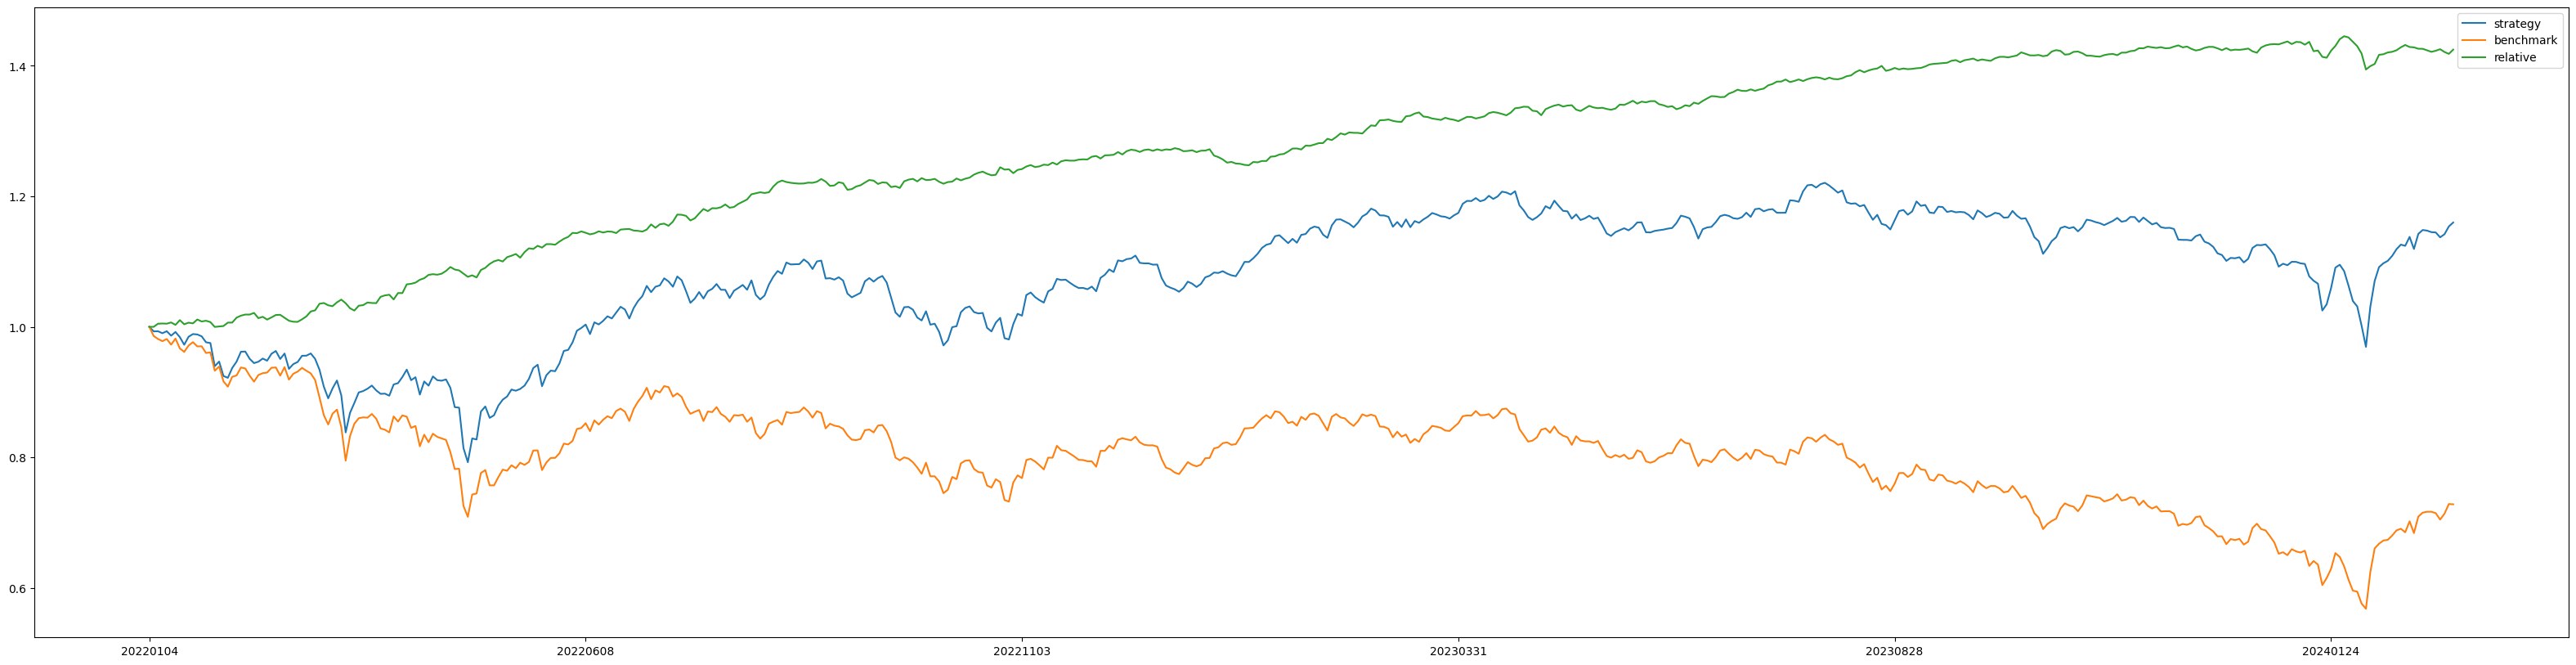

In [7]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew,550,结合李政打分
info_s = func_backtest(citic_share_limit=0.04, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.04,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.015, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 1000000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

0 20220104 100270236.90052012 80300505.00562468 19699494.994375326 100000000.0 nan 26 0.7202829897702853 nan
1 20220105 99648050.39887145 16737187.10625337 63563317.89937129 80300505.00562468 1.0078017258053475 109 0.43685422127565315 0.0
2 20220106 99808564.70010248 612.2399966365192 41024727.39495176 16737187.10625337 1.0140321859757437 156 0.4809944843117176 0.0
3 20220107 98999237.69396412 699.2493436266939 14211163.754066868 3660194.362792306 1.0092481834319336 167 0.5694133293454702 -0.004784002543810173
4 20220110 99205267.42860708 623.3818842406891 25765746.912935648 4283729.864968368 1.007982637448959 189 0.46226194012603106 -0.006049548526784632
5 20220111 98665931.72631781 90.52302643794155 25178702.49247285 5967706.466808708 1.0112315635752047 206 0.4949356701245451 -0.0028006224005390212
6 20220112 99740831.90903787 251.08983954548785 22484864.0415577 3932560.641106103 1.0128195974790692 216 0.44004271566564057 -0.0012125884966744938
7 20220113 98767998.66982229 370.072461

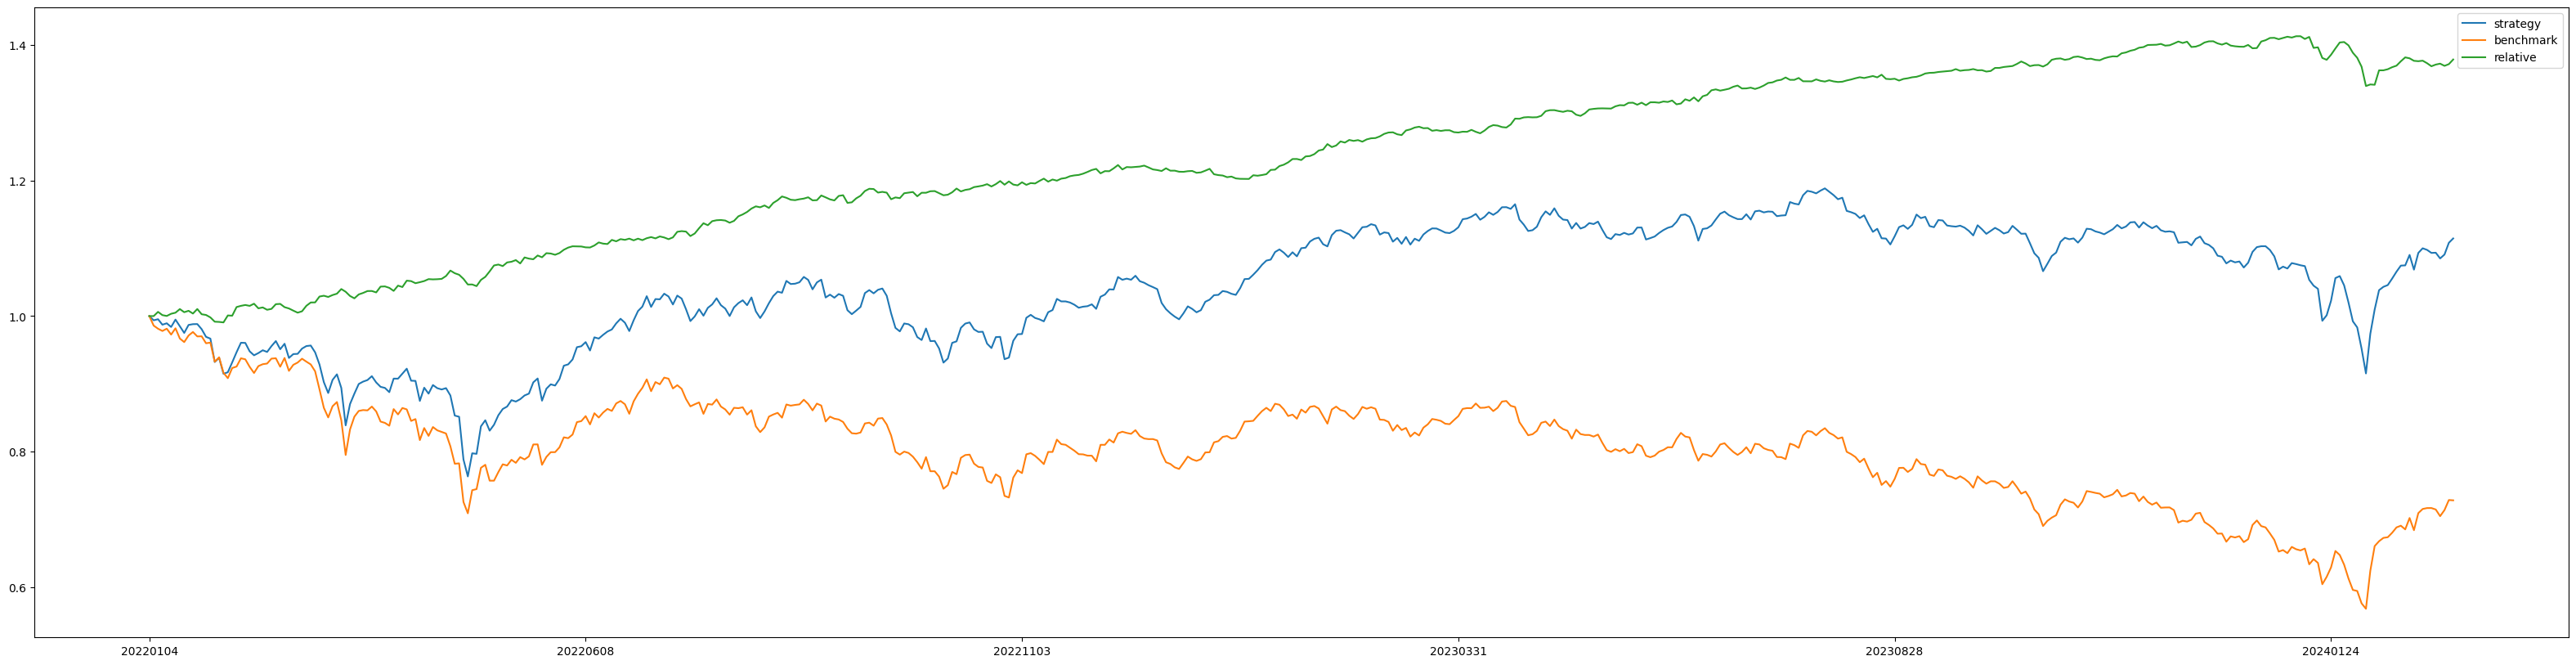

In [39]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew,550,结合李政打分
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

0 20220104 1002237576.8826597 831119509.9978427 168880490.00215745 1000000000.0 nan 29 0.773743717381027 nan
1 20220105 990889403.2951239 42964054.46598797 798374492.792406 831119509.9978427 1.0064063406714752 151 0.5178390939732235 0.0
2 20220106 995781611.323471 39.63829266111634 323120000.7714062 48107167.15294715 1.0117311649810972 205 0.5544560144640867 0.0
3 20220107 986029171.0446079 912.6640911365394 165645901.7979011 49865300.77163838 1.0110209562484285 228 0.6027425881159206 -0.0007102087326686934
4 20220110 989392971.0528868 905.1420424277894 174180816.14539987 25857330.252660535 1.0099717789677949 250 0.5316877997882783 -0.0017593860133022776
5 20220111 983279094.0303268 360.07777421036735 217444227.12095767 86860304.00710101 1.013343968570962 278 0.5143219998559059 0.0
6 20220112 995670760.1464378 877.2371423006989 254468532.52108592 38660350.3838699 1.013963824397734 305 0.5045460869072875 0.0
7 20220113 984272487.2066289 534.262678996427 195333571.86321673 99607670.80424

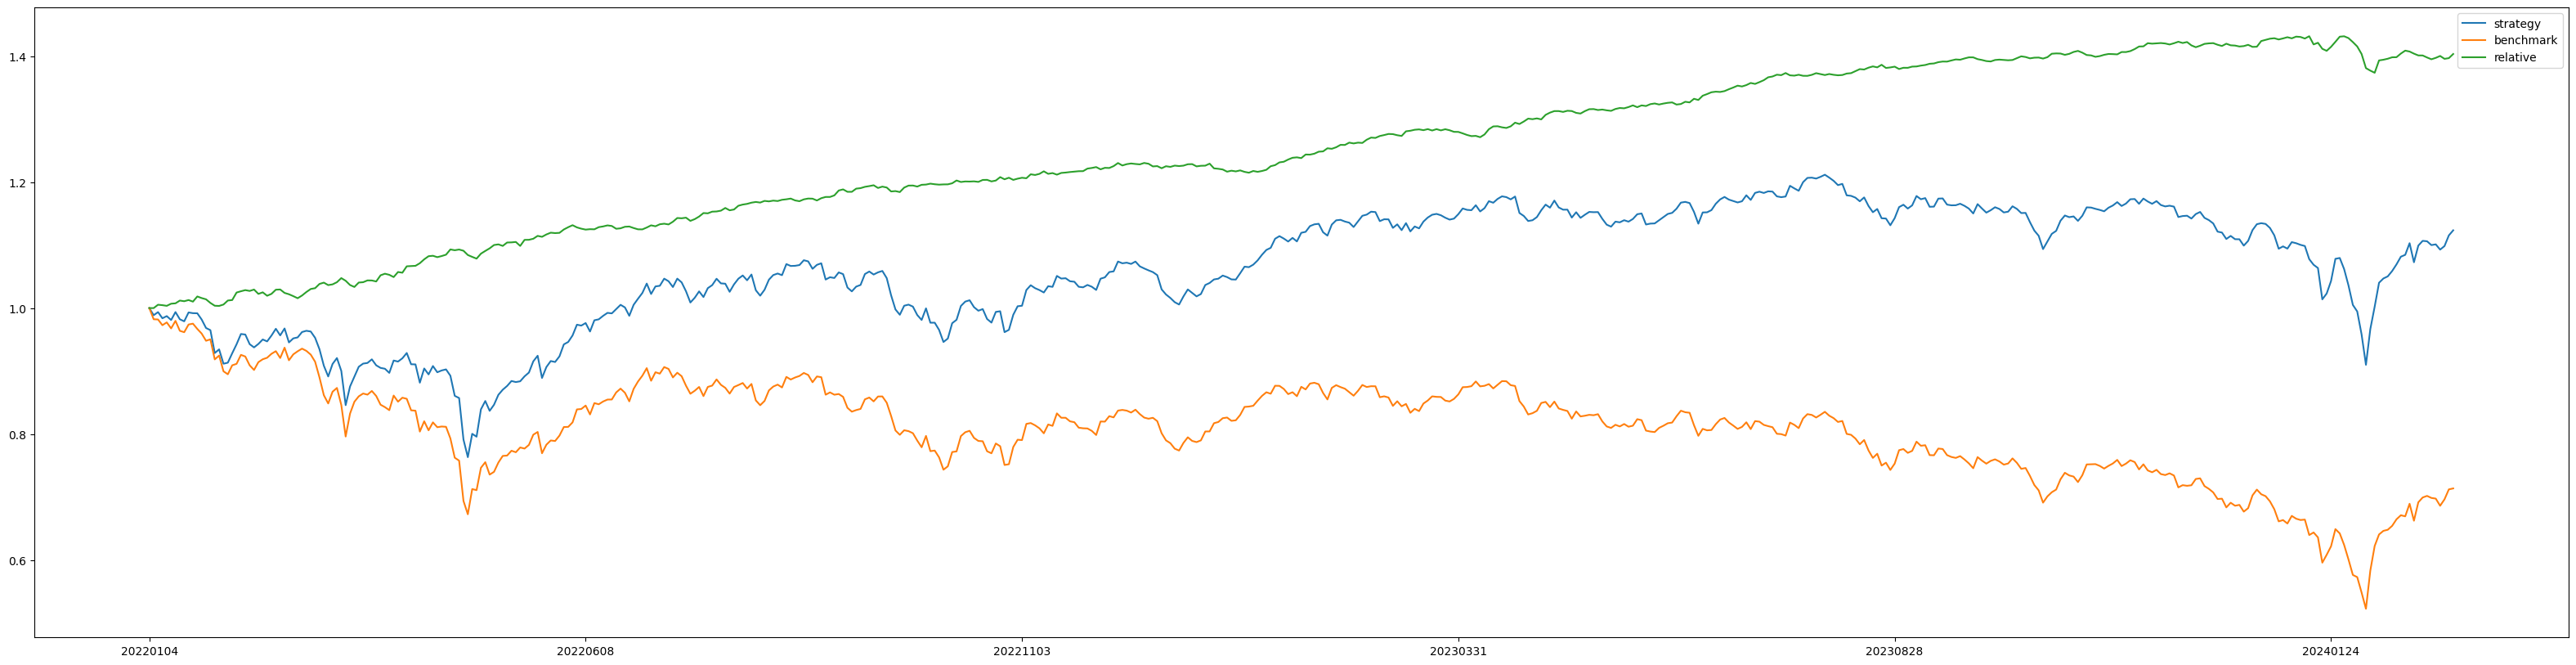

In [34]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew,333,结合李政打分
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 1000000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [29]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew,333,结合李政打分
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 1000000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

0 20220104 1002254678.0894649 824981344.7885306 175018655.2114695 1000000000.0 nan 29 0.7612444153007721 nan
1 20220105 991064135.5191436 48887398.58503586 786312983.4640458 824981344.7885306 1.0065638102796064 155 0.5144034187148624 0.0
2 20220106 995493469.056863 541.361514929001 331322693.3425928 48887398.58503586 1.0114207161569284 216 0.5521405590410218 0.0
3 20220107 985849772.1339072 543.0113406516612 171342073.92354032 57495515.25532718 1.010816908284419 245 0.6016895114993539 -0.0006038078725094653
4 20220110 989286009.3096826 65.97261577837412 180304100.46154127 25853986.765661247 1.0098418286827004 278 0.5348291818342233 -0.0015788874742279635
5 20220111 983430133.7671497 74.12512644274238 222802850.65083557 77319086.1361171 1.01347414580796 290 0.5100912547812891 0.0
6 20220112 994936940.5123962 1983699.2591136217 249717536.3742419 36028171.96052949 1.0131922976885055 313 0.5038206607346035 -0.0002818481194544198
7 20220113 983878638.3635174 10.917977539114418 223890412.852

0 20220104 100270224.25535469 81779205.69646864 18220794.30353138 100000000.0 nan 24 0.7559286874404693 nan
1 20220105 99633615.07035506 28891944.79597845 52887260.90049018 81779205.69646864 1.0113802430523977 97 0.5217652099703032 0.0
2 20220106 100240908.56874533 849.3431023994036 47573911.70634389 28891944.79597845 1.0178631457220546 160 0.5511647561178349 0.0
3 20220107 99236730.73289599 524.380591996247 14767090.628226064 3994956.6000556126 1.0169290461364975 176 0.5832514642220991 -0.0009340995855571244
4 20220110 99597716.40989864 432.7870034972909 23016715.83878136 4031075.264753256 1.0161060295281148 210 0.5156011087536253 -0.0017571161939398117
5 20220111 99010659.61222985 632023.3507103453 22783997.305344347 7561712.209936734 1.0197633617687545 227 0.5189130066238888 0.0
6 20220112 100080386.82060891 668.9386037047079 26981034.102954164 3253620.557331745 1.0185849901320687 242 0.4906222556829985 -0.001178371636685771
7 20220113 98867510.16445184 906.3206896655029 21834547.97

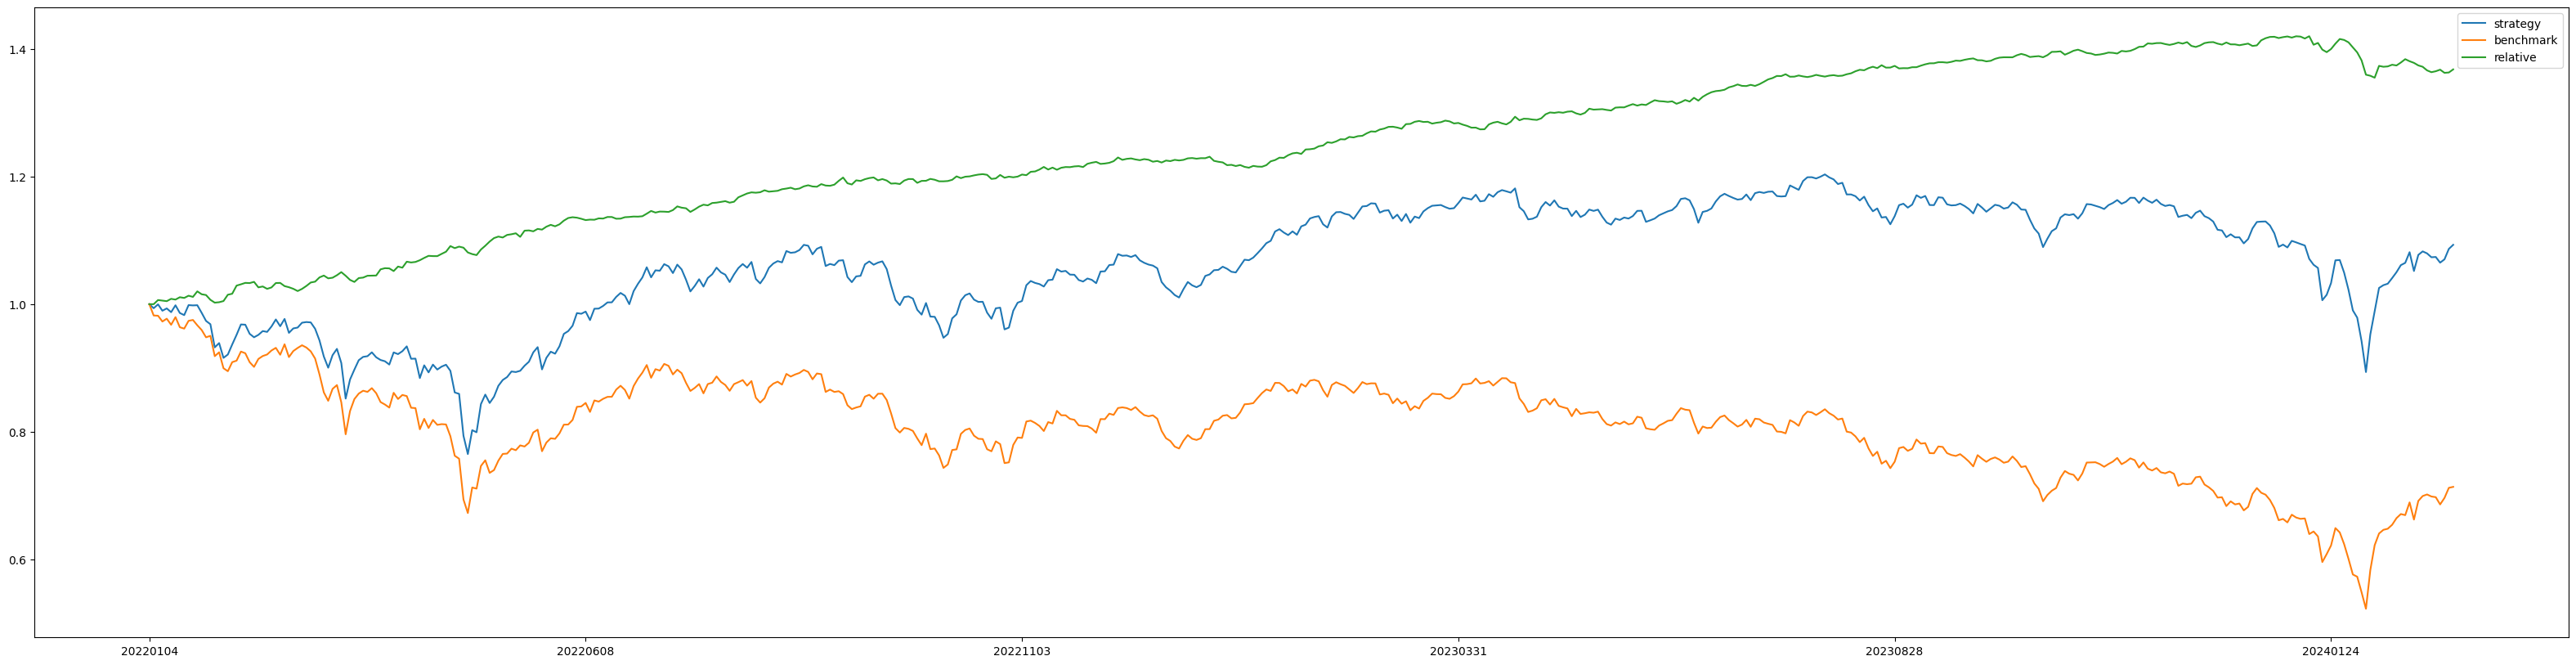

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew,333,结合李政打分
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

0 20240102 100391293.4424111 72338352.92222925 27661647.0777708 100000000.0 nan 34 0.6892771631745126 nan
1 20240103 100358304.57598102 158.2996522573335 74551503.9231879 72338352.92222925 1.002706188076425 133 0.5776670221513648 0.0
2 20240104 99775311.58794942 908.9416510492156 24914354.672216274 6359021.493214973 1.0051631915158237 171 0.41794906264349646 0.0
3 20240105 98724301.28864989 618.4063294036605 11060405.907223571 4045321.113829883 1.007154769625318 175 0.5352134476002075 0.0
4 20240108 96704007.3270818 378.58070017334376 15249660.182129482 3366791.4805508708 1.0059536625781345 191 0.614100840891536 -0.0012011070471835694
5 20240109 96879602.67304073 352.68421867641155 16258046.443341358 4158229.995682322 1.0056974378892867 192 0.6256185623714803 -0.0014573317360313531
6 20240110 96603444.52812067 704.1356714505703 11521950.430441635 5060913.977107982 1.0083251186317175 192 0.5755190157997229 0.0
7 20240111 97660905.25257216 119.91690876544453 17752907.200790837 3268642.18

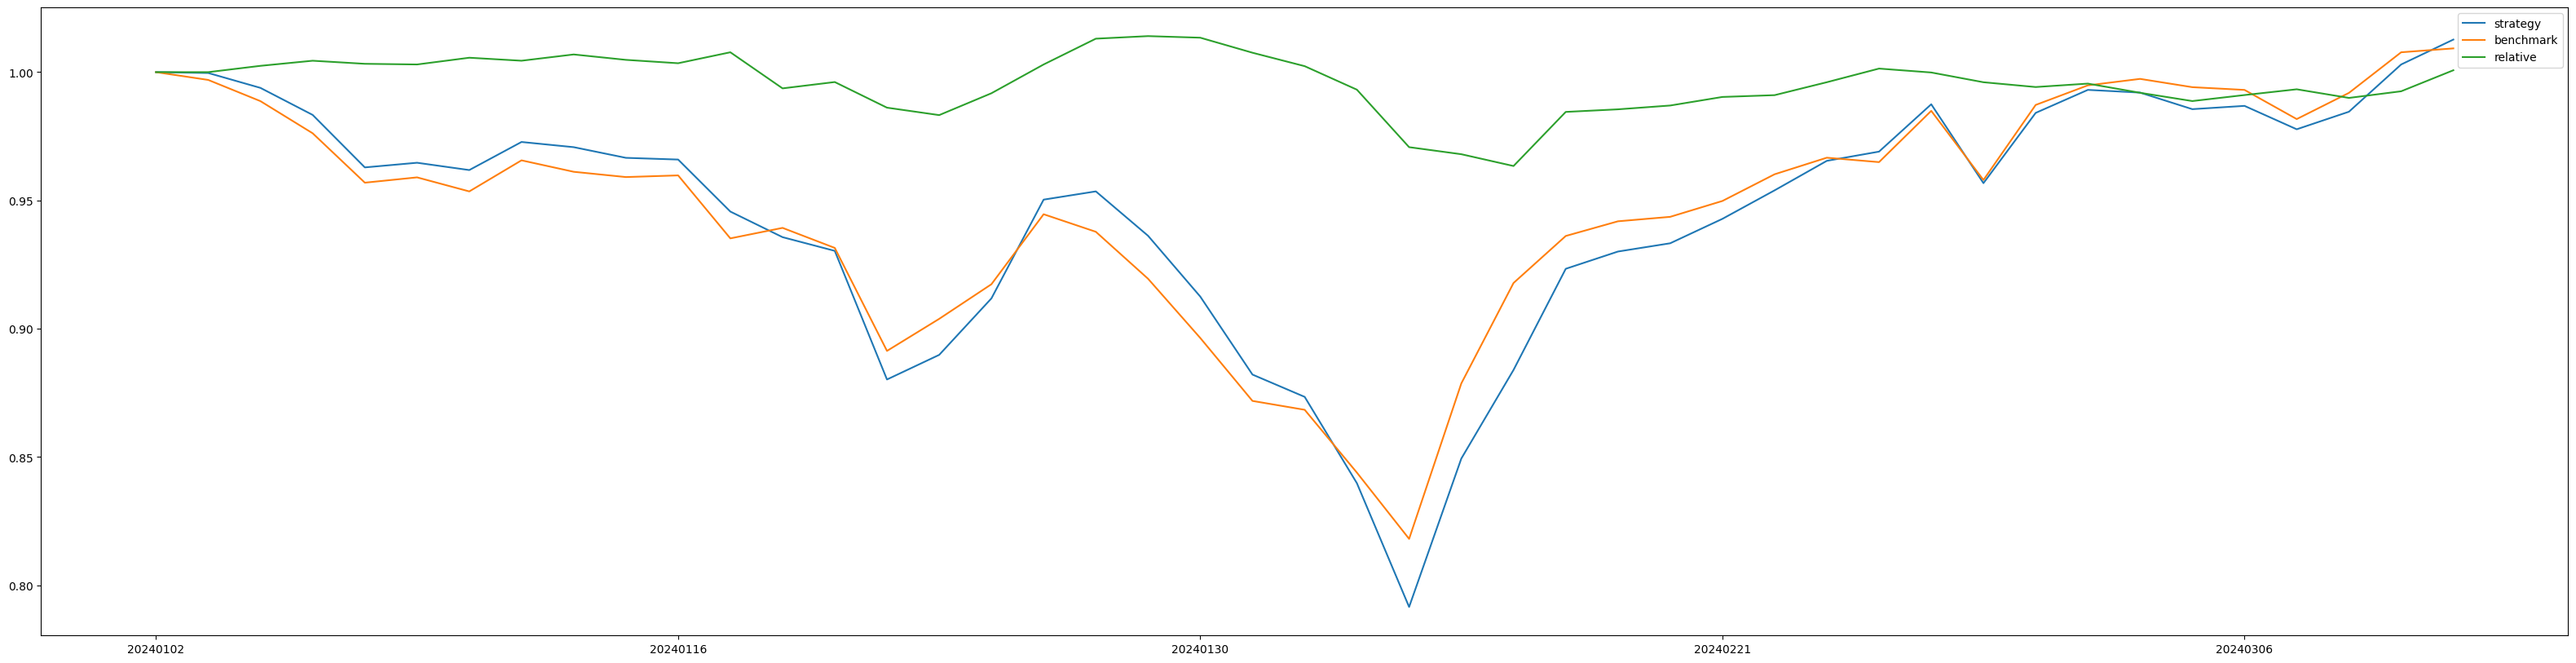

In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew,333,结合李政打分
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

In [31]:
from prefetch_generator import BackgroundGenerator
import torch

class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

class SDataset(torch.utils.data.Dataset):
    def __init__(self,date_list,function) -> None:
        self.date_list=date_list
        self.function=function

    def __getitem__(self, index):
        date = date_list[index]
        date_str = date.strftime('%Y%m%d')
        result=self.function(date_str,load=False)
        # ret = params.pre_close.pct_change().shift(-1)
        # ret = ret.loc[date]
        # ret.index = ['%06d'%int(x) for x in ret.index]
        # ret = ret.reindex(index=result['1d_min'].columns.tolist()).rank(pct=True).fillna(0.5)
        # if date_str < '20231231': result['1d_min'] = result['1d_min'] + ret * 0.003
        # else: result['1d_min'] = result['1d_min'] + ret * 0.01
        # result['1d_min'] = result['1d_min'].rank(axis=1,pct=True).fillna(0.5)
        return date_str,result

    def __len__(self):
        return len(self.date_list)

dl = DataLoaderX(SDataset(date_list,get_alpha_dict),collate_fn=lambda x:x[0],batch_size=1,num_workers=10,shuffle=False,drop_last=False)
for i,batch in tqdm.tqdm(enumerate(dl),total=len(dl)):
    date_str,result = batch
    score = result['1d_min']
    daily_alpha = result['1d_daily']
    with open(os.path.join(r'/home/datamake8/data0/min_alpha_agg/update20240613',date_str+'.pkl'),'wb') as f:
        pkl.dump((score,daily_alpha),f)

100%|███████████████████████████████████████████████████████████████| 529/529 [01:59<00:00,  4.43it/s]


In [ ]:
#最终_tabnet，调整印花税，新市值约束，normqcut+nodenew，中证1000,结合李政打分
info_s = func_backtest(citic_share_limit=0.005, # 持仓期间行业偏离比例
cmvg_share_limit=0.08, # 持仓期间市值偏离比例
citic_share_limit_low=0.005,
cmvg_share_limit_low=0.08,
stk_holding_limit=0.01,
stk_holding_limit_low=0.01,
stk_trade_share=5, # 个股每分钟参与比例上限
buy_rank_ratio=0.02, # 开仓阈值
sell_rank_ratio_morning=0.1, # 平仓阈值
sell_rank_ratio_noon=0.05,
# divid_ratio=0.0015,
cash_limit_high=0.1,
initial_money = 100000000,
inday_ratio=1,
min_turn_limit=1,
save_result=True)

0.05656576156616211
4.172111749649048
0 20220104 100240327.7117453 82820847.18640336 17179152.813596647 100000000.0 nan 23 0.7548422827944973 nan
0.05853867530822754


KeyboardInterrupt: 